In [1]:
import os
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import matplotlib as mpl
import gseapy as gp
import seaborn as sns

In [2]:
figpath = '/stanley/WangLab/kamal/figures/projects/manifesto/regions_human_lymph_node/'
os.makedirs(figpath, exist_ok=True)
dpi = 500

# Load

In [3]:
adata = sc.read_h5ad('/stanley/WangLab/kamal/data/technologies/xenium/human_lymph_node/filtered/adata.h5ad')

In [4]:
max_mag = 2

# Scale
sc.pp.scale(adata, layer='lowpass')
sc.pp.scale(adata, layer='highpass')

# Clip
X = adata.layers['lowpass']
X[X > max_mag] = max_mag
X[X < -max_mag] = -max_mag
X = adata.layers['highpass']
X[X > max_mag] = max_mag
X[X < -max_mag] = -max_mag

# Spatially arrange
adata.obsm['spatial'][:,1] *= -1

# Set figure size
width = adata.obsm['spatial'][:,0].ptp()
height = adata.obsm['spatial'][:,1].ptp()
set_width = 4
norm = set_width / width
sc.set_figure_params(figsize=(set_width, height*norm))

# Plot filtered gene

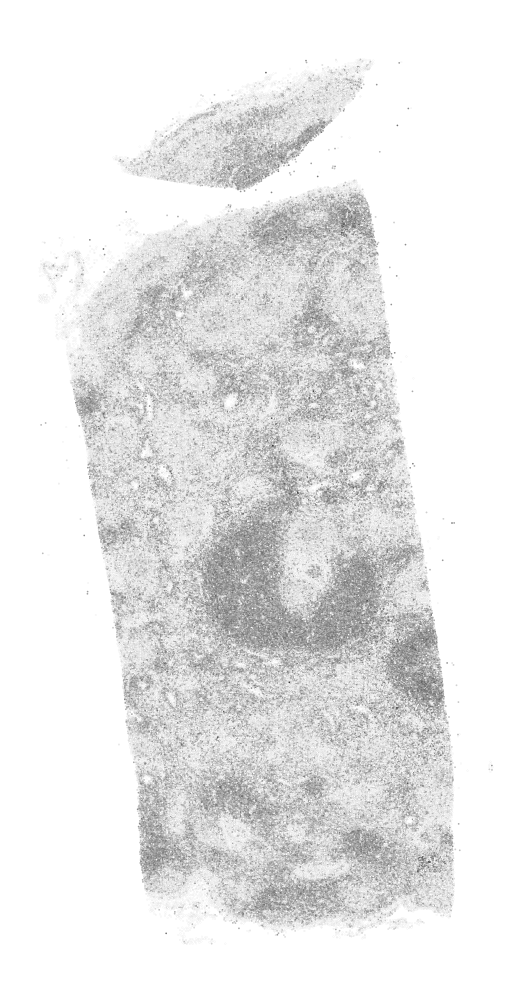

In [6]:
gene = 'TRAC'
points = adata.obsm['spatial']
plt.figure(figsize=(4,8))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.01,
    s=0.5,
    c=np.array(adata[:,[gene]].X.todense()).flatten(),
    cmap='Greys',
)
plt.axis('off')
filename = os.path.join(figpath, f'{gene}_normalized_greys.png')
plt.savefig(filename, dpi=dpi)
plt.show()

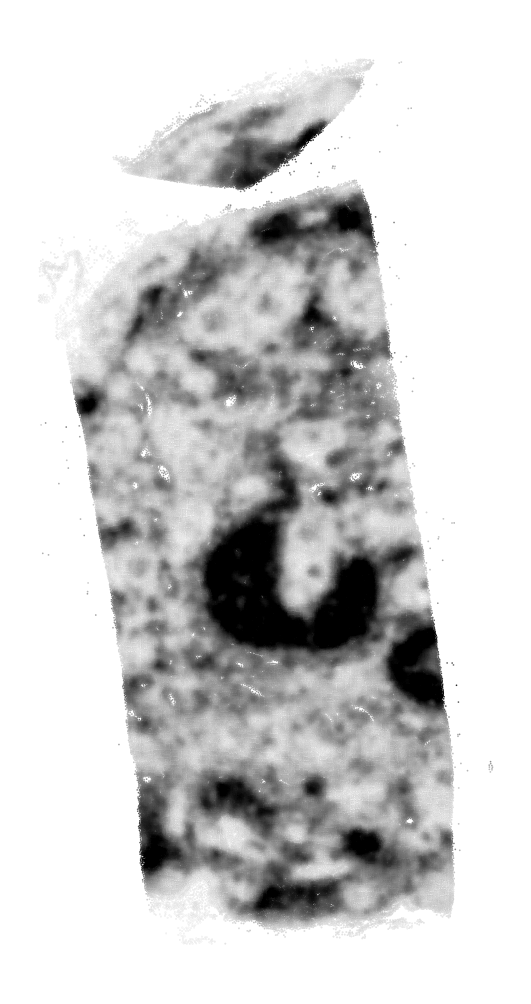

In [8]:
gene = 'TRAC'
points = adata.obsm['spatial']
plt.figure(figsize=(4,8))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.01,
    s=0.5,
    c=adata[:,[gene]].layers['lowpass'].flatten(),
    cmap='Greys',
)
plt.axis('off')
filename = os.path.join(figpath, f'{gene}_lowpass_greys.png')
plt.savefig(filename, dpi=dpi)
plt.show()

# PCA

In [5]:
n_pcs = 10
pca = PCA(n_components=n_pcs, random_state=0)
adata.obsm['X_pca_lowpass'] = pca.fit_transform(adata.layers['lowpass'])
adata.varm['X_pca_lowpass'] = pca.components_.T

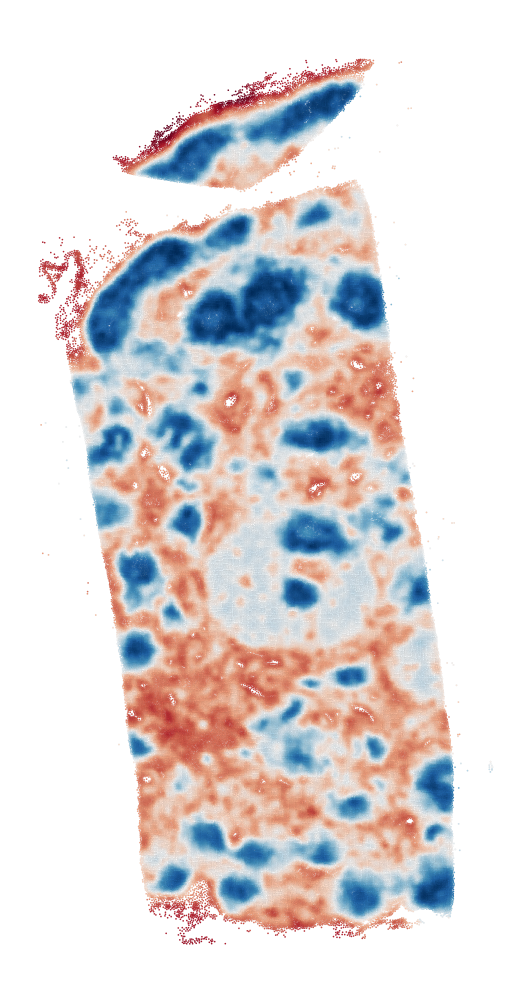

In [32]:
points = adata.obsm['spatial']
plt.figure(figsize=(4,8))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.01,
    s=0.5,
    c=adata.obsm['X_pca_lowpass'][:,0],
    cmap='RdBu_r',
)
plt.axis('off')
filename = os.path.join(figpath, f'PC1_lowpass.png')
plt.savefig(filename, dpi=300)
plt.show()

# Clustering

In [6]:
n_regions = 3
kmeans = KMeans(n_clusters=n_regions, random_state=0)
kmeans.fit(adata.obsm['X_pca_lowpass'])
adata.obs['region'] = kmeans.labels_.astype(str)

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [23]:
regions = sorted(adata.obs['region'].unique())
colors = np.array(sc.pl.palettes.default_28)[[0,5,9]]
# colors = [
#     '#1B5B9C',
#     '#931A28',
#     '#FFC8C8',
#     # '#AADCFF',
# ]
palette = {region:color for region,color in zip(regions,colors)}
adata.obs['region_color'] = adata.obs['region'].map(palette)

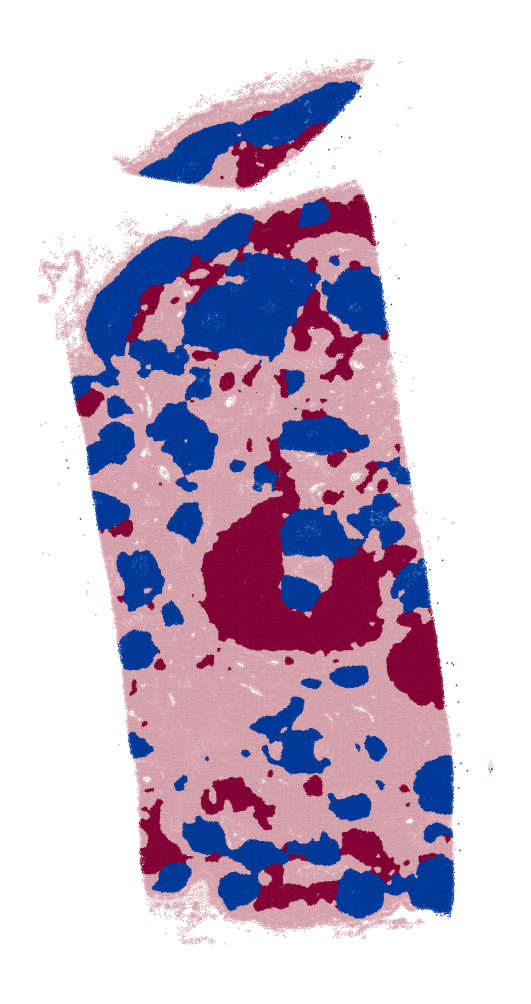

In [24]:
points = adata.obsm['spatial']
plt.figure(figsize=(4,8))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.01,
    s=0.5,
    c=adata.obs['region_color'],
)
plt.axis('off')
filename = os.path.join(figpath, f'regions.png')
plt.savefig(filename, dpi=dpi)
plt.show()

In [8]:
adata.uns['log1p']['base'] = None

In [10]:
sc.tl.rank_genes_groups(adata, groupby='region', layer='lowpass')
sc.tl.dendrogram(adata, groupby='region', use_rep='X_pca_lowpass')

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


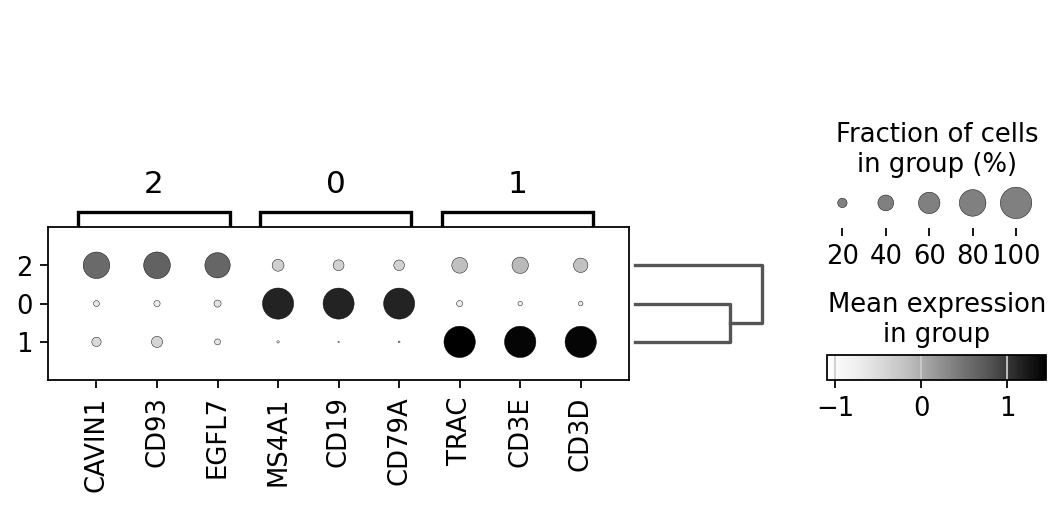

In [12]:
fig = plt.figure(figsize=(8,3))
ax = plt.gca()
sc.pl.rank_genes_groups_dotplot(adata, groupby='region', n_genes=3, layer='lowpass', ax=ax, cmap='Greys')
figname = 'region_markers.png'
savepath = os.path.join(figpath, figname)
fig.savefig(savepath, dpi=dpi, bbox_inches='tight')

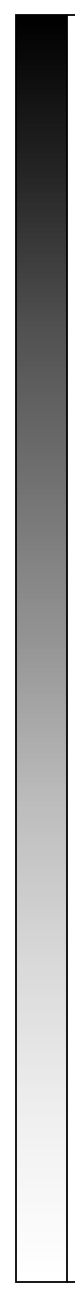

In [9]:
fig, ax = plt.subplots(figsize=(0.4,8), layout='constrained')

cmap = mpl.cm.Greys
norm = None

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='')

plt.grid(None)
plt.gca().set_yticks(np.arange(0,1.1,1), ['']*2)

figname = 'expression_colorbar_greys.png'
savepath = os.path.join(figpath, figname)
plt.savefig(savepath, dpi=dpi)

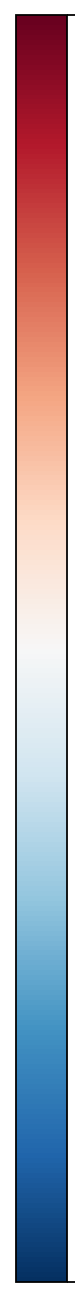

In [31]:
fig, ax = plt.subplots(figsize=(0.4,8), layout='constrained')

cmap = mpl.cm.RdBu_r
norm = None

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='')

plt.grid(None)
plt.gca().set_yticks(np.arange(0,1.1,1), ['']*2)

figname = 'pc_colorbar.png'
savepath = os.path.join(figpath, figname)
plt.savefig(savepath, dpi=dpi)